# Deep learning

In [11]:
from tensorflow.keras import models, layers, utils, backend as K
import matplotlib.pyplot as plt
import shap
import pandas as pd
import tensorflow as tf

2022-06-21 17:27:31.930228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-21 17:27:31.930276: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


importar parâmetros por json para testar várias possibilidades da rede neural

In [9]:
import datetime, json
now = datetime.datetime.now()
config = dict()
config['date'] = "{}_{}_{}-{}:{}".format(now.day, now.month, now.year, now.hour, now.minute)
config['hidden_layers'] = ['sigmoid', 'sigmoid']
config['epoch'] = 50000
config['normalization'] = 'standardScaler'
config['optimizer'] = 'SGD'
config['loss'] = 'mean_absolute_error'

with open("parametros/regres_config_" + config['date'] + ".json", "w") as file:
    json_content = json.dump(config, file, indent = 4)

In [12]:
from sklearn.preprocessing import StandardScaler
def load_data():
    data = pd.read_csv('sinaisvitais_hist.txt', names=['id', 'pSis', 'pdiast', 'qPa', 'pulso', 'resp', 'grav', 'classe'])

    X_variables = data.iloc[:, 3:6]
    y_variables = data.iloc[:, 6]
    return X_variables, y_variables

from sklearn.model_selection import train_test_split
#X, y = load_normalized_data_regression()
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X, y = load_data()
scaler_x.fit(X)
X = scaler_x.transform(X)
print(X)
y = (y-min(y)) / (max(y)-min(y)) - 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
X_test = X_test
y_test = y_test
X_train = X_train
y_train = y_train
print(X, y)
print(max(y), min(y))

[[-1.32822746 -0.80499737 -0.3133257 ]
 [-1.35030829  0.7469566   0.55705413]
 [ 1.10974081  0.1845856  -1.10952296]
 ...
 [ 0.5515367   1.39476481 -0.35302883]
 [ 1.04175395 -0.29690057  1.25951643]
 [-0.17016771  0.90142652  1.42859837]]
[[-1.32822746 -0.80499737 -0.3133257 ]
 [-1.35030829  0.7469566   0.55705413]
 [ 1.10974081  0.1845856  -1.10952296]
 ...
 [ 0.5515367   1.39476481 -0.35302883]
 [ 1.04175395 -0.29690057  1.25951643]
 [-0.17016771  0.90142652  1.42859837]] 0     -0.192937
1      0.333476
2     -0.241406
3     -0.335470
4     -0.233508
         ...   
795   -0.498761
796   -0.181974
797   -0.331672
798    0.108509
799   -0.103027
Name: grav, Length: 800, dtype: float64
0.5 -0.5


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>, <AxesSubplot:>]], dtype=object)

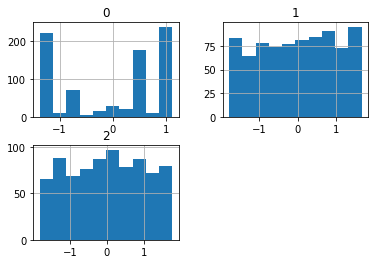

In [200]:
pd.DataFrame(X).hist()

In [16]:
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

inputs = layers.Input(name="input", shape=(3,))
ant = layers.Dense(name="primeira", units=3,activation='relu')(inputs)
i = 0
for layer in config['hidden_layers']:
    atual = layers.Dense(name=str(i), units=3,activation=layer)(ant)
    ant = atual
    i+=1

outputs = layers.Dense(name="output", units=1, 
                       activation='sigmoid', kernel_initializer=initializer)(atual)
model = models.Model(inputs=inputs, outputs=outputs, 
                     name="Perceptron")
model.summary()

Model: "Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 primeira (Dense)            (None, 3)                 12        
                                                                 
 0 (Dense)                   (None, 3)                 12        
                                                                 
 1 (Dense)                   (None, 3)                 12        
                                                                 
 output (Dense)              (None, 1)                 4         
                                                                 
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


<tf.Tensor: shape=(800, 3), dtype=float32, numpy=
array([[-1.3282274 , -0.8049972 , -0.31332573],
       [-1.3503083 ,  0.7469568 ,  0.55705404],
       [ 1.1097409 ,  0.18458574, -1.109523  ],
       ...,
       [ 0.55153674,  1.3947648 , -0.35302895],
       [ 1.0417539 , -0.2969004 ,  1.2595164 ],
       [-0.17016768,  0.90142655,  1.4285983 ]], dtype=float32)>

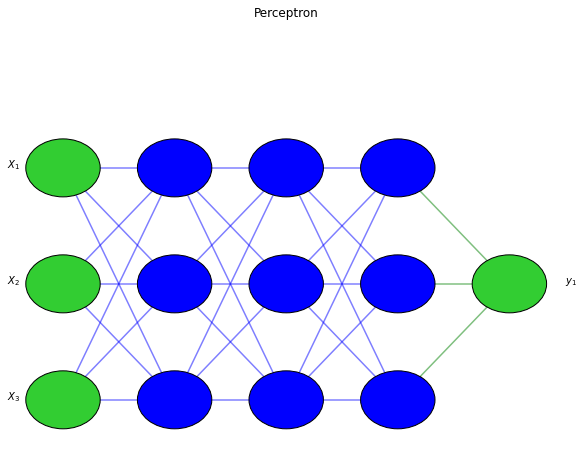

<Figure size 432x288 with 0 Axes>

In [21]:
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers



'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

visualize_nn(model)
plt.savefig('graficos/rede_neural.svg')

In [18]:
import tensorflow as tf
def R2(y, y_hat):
    ss_res =  K.sum(K.square(y - y_hat)) 
    ss_tot = K.sum(K.square(y - K.mean(y))) 
    return ( 1 - ss_res/(ss_tot + K.epsilon()) )
# compile the neural network
model.compile(optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.01)
, loss=config['loss'], 
              metrics=[tf.keras.metrics.MeanSquaredError()])

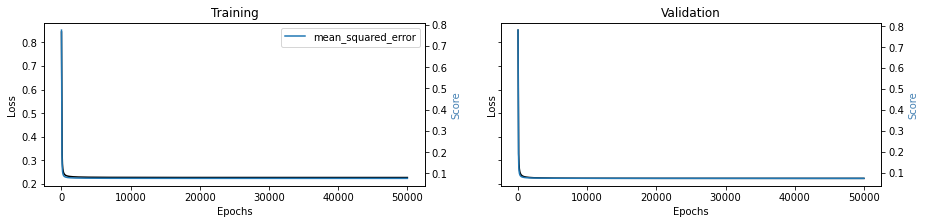

In [19]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

chk = tf.keras.callbacks.ModelCheckpoint("myModel.h5", monitor='val_loss', save_best_only=True) 
callbacks_list = [chk, tensorboard_callback]
# train/validation
training = model.fit(x=X, y=y, batch_size=64, epochs=config['epoch'], shuffle=True, verbose=0, validation_split=0.3, callbacks=callbacks_list)
# plot
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
## training    
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

## validation    
ax[1].set(title="Validation")    
ax22 = ax[1].twinx()    
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')    
for metric in metrics:          
    ax22.plot(training.history['val_'+metric], label=metric) 
    ax22.set_ylabel("Score", color="steelblue")    
plt.show()

In [19]:
history = pd.DataFrame(training.history)
history

,loss,mean_squared_error,val_loss,val_mean_squared_error
0,0.420989,0.420989,0.389410,0.389410
1,0.358119,0.358119,0.332379,0.332379
2,0.307065,0.307065,0.286279,0.286279
3,0.266253,0.266253,0.249716,0.249716
4,0.233786,0.233786,0.220302,0.220302
...,...,...,...,...
995,0.076550,0.076550,0.072623,0.072623
996,0.076550,0.076550,0.072623,0.072623
997,0.076549,0.076549,0.072623,0.072623
998,0.076549,0.076549,0.072623,0.072623


In [20]:
import pandas as pd
predict = model.predict(X_test)
df_predict = pd.DataFrame()
df_predict['real'] = y_test
df_predict['previsao'] = predict
df_predict

8/8 [==============================] - 0s 1ms/step


,real,previsao
27,0.089903,0.000390
334,-0.395185,0.000382
730,-0.320218,0.000386
392,-0.499274,0.000390
495,0.259755,0.000391
...,...,...
390,0.127952,0.000391
20,0.310129,0.000390
220,0.254075,0.000390
16,0.126225,0.000390


In [103]:

print(model.predict(X_test.iloc[0:1, :]), y_test.iloc[0])


1/1 [==============================] - 0s 22ms/step
[[0.52671725]] 0.5899033245519928


In [115]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
mse = mean_squared_error(y_test, predict)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, predict)
r_squared = r2_score(y_test, predict)
print(mse, rmse, mae, r_squared)

0.0671785735787591 0.2591882975343584 0.20563714215718 -0.14300702635731288
